Prep

In [1]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
pd.set_option('display.max_rows', 200)

from tqdm import tqdm
import getpass
import logging

logging.basicConfig(level=logging.INFO)

In [2]:
from adapter_covid19.data_structures import Scenario, ModelParams
from adapter_covid19.simulator import Simulator

Initialize simulator

In [3]:
data_path = f"/home/{getpass.getuser()}/adaptER-covid19/tests/adapter_covid19/data"

simulator = Simulator(data_path)

Inialize scenarios

In [4]:
from adapter_covid19.scenarios import BASIC_SCENARIO

In [5]:
BASIC_SCENARIO

Scenario(lockdown_recovery_time=1, lockdown_exited_time=0, lockdown_start_time=10, lockdown_end_time=59, furlough_start_time=10, furlough_end_time=202, simulation_end_time=202, new_spending_day=10, ccff_day=10, loan_guarantee_day=10, model_params=ModelParams(economics_params={}, gdp_params={}, personal_params={'default_th': 300, 'max_earning_furloughed': 30000, 'alpha': 5, 'beta': 20}, corporate_params={'beta': 1.4, 'large_cap_cash_surplus_months': 6}), simulate_states={}, datasources={'gdp': <class 'adapter_covid19.datasources.RegionSectorAgeDataSource'>, 'workers': <class 'adapter_covid19.datasources.RegionSectorAgeDataSource'>, 'furloughed': <class 'adapter_covid19.datasources.SectorDataSource'>, 'keyworker': <class 'adapter_covid19.datasources.SectorDataSource'>}, gdp=None, workers=None, furloughed=None, keyworker=None, _has_been_lockdown=False, _utilisations={}, is_loaded=False)

In [6]:
scenarios = { 
#     'basic scenario': BASIC_SCENARIO,
#     '5 days only': Scenario(
#         lockdown_recovery_time=1,
#         lockdown_start_time=5,
#         lockdown_end_time=30,
#         furlough_start_time=5,
#         furlough_end_time=30,
#         simulation_end_time=5,
#         new_spending_day=5,
#         ccff_day=5,
#         loan_guarantee_day=5,
#         model_params= ModelParams(
#             economics_params={},
#             gdp_params={},
#             personal_params={
#                 'default_th':300,
#                 'max_earning_furloughed':30_000,
#                 'alpha':5,
#                 'beta':20,
#             },
#             corporate_params={
#                 'beta':1.4,
#                 'large_cap_cash_surplus_months':6,
#             },
#         ),
#     ),
    '109 days': Scenario(
        lockdown_recovery_time=1,
        lockdown_start_time=5,
        lockdown_end_time=30,
        furlough_start_time=5,
        furlough_end_time=30,
        simulation_end_time=109,
        new_spending_day=5,
        ccff_day=5,
        loan_guarantee_day=5,
        model_params= ModelParams(
            economics_params={},
            gdp_params={},
            personal_params={
                'default_th':300,
                'max_earning_furloughed':30_000,
                'alpha':5,
                'beta':20,
            },
            corporate_params={
                'beta':1.4,
                'large_cap_cash_surplus_months':6,
            },
        ),
    ),
}

INFO:/home/chefei/adaptER-covid19/src/adapter_covid19/simulator.py:
##################################################
# Scenario name: 109 days
# Scenario details:
lockdown_recovery_time:1
lockdown_exited_time:0
lockdown_start_time:5
lockdown_end_time:30
furlough_start_time:5
furlough_end_time:30
simulation_end_time:109
new_spending_day:5
ccff_day:5
loan_guarantee_day:5
model_params:{'economics_params': {}, 'gdp_params': {}, 'personal_params': {'default_th': 300, 'max_earning_furloughed': 30000, 'alpha': 5, 'beta': 20}, 'corporate_params': {'beta': 1.4, 'large_cap_cash_surplus_months': 6}}
simulate_states:{}
datasources:{'gdp': <class 'adapter_covid19.datasources.RegionSectorAgeDataSource'>, 'workers': <class 'adapter_covid19.datasources.RegionSectorAgeDataSource'>, 'furloughed': <class 'adapter_covid19.datasources.SectorDataSource'>, 'keyworker': <class 'adapter_covid19.datasources.SectorDataSource'>}
gdp:None
workers:None
furloughed:None
keyworker:None
_has_been_lockdown:False
_util

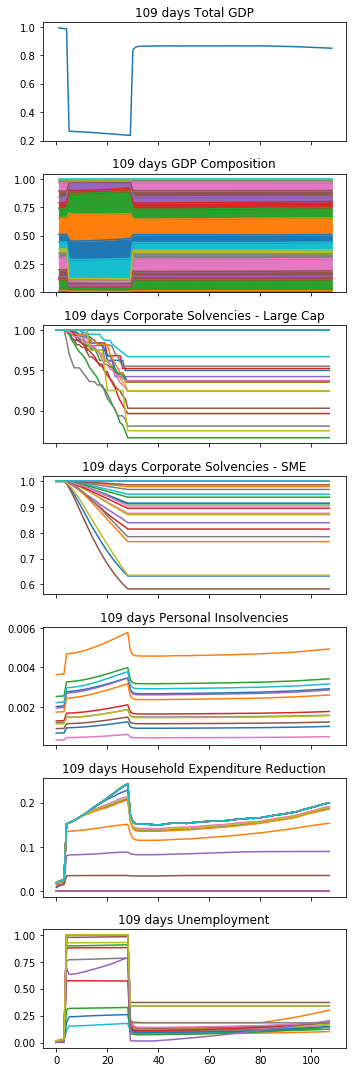

In [7]:
result = simulator.simulate_multi(scenarios, show_plots=True, figsize=(5, 15))

Metrics

In [8]:
econ, states = result['109 days']

In [9]:
from adapter_covid19.metrics import get_quarterly_gdp_decline, get_quarterly_demand_decline

In [10]:
starting_date = pd.Timestamp('2020-03-28').date()

In [11]:
get_quarterly_gdp_decline(starting_date, states)

,GDP decline simulation,GDP decline estimates
2020-03-31,0.986964,0.97
2020-06-30,0.859618,0.75
2020-09-30,0.849023,NaN
2020-12-31,NaN,0.86


In [12]:
get_quarterly_demand_decline(starting_date, econ, states)

,Demand decline simulation,Demand decline estimates
2020-03-31,0.976318,0.70
2020-06-30,0.831697,0.55
2020-09-30,0.811375,NaN
